In [20]:
import time 
import re
import os
import boto3
import json
import logging 

import numpy as np
import pandas as pd

from sagemaker.session import Session

# Image IO
from PIL import Image

# Morphological filtering
from skimage.morphology import opening
from skimage.morphology import disk

# Connected component filtering
import cv2

In [19]:
# Amazon Textract client and Sagemaker session
textract = boto3.client('textract')
s3 = boto3.client('s3')
session = Session()

# initiate s3 bucket and corresponding data/output folder
bucket = 'ran-s3-systemic-risk'

data_png_folder = 'Input/X-17A-5-PNG-SUBSETS/'
file_name = '1146184-2010-02-25-p4.png'
sub_dir = '-'.join(file_name.split('.')[0].split('-')[:-1]) + '/'

# retrieving downloaded files from s3 bucket
s3.download_file(bucket, data_png_folder + sub_dir + file_name, 'original.png')

# Improving PNG Textract 

In [21]:
black = 0
white = 255
threshold = 160

# Open input image in grayscale mode and get its pixels.
img = Image.open("original.png").convert("LA")
pixels = np.array(img)[:,:,0]

# Remove pixels above threshold
pixels[pixels > threshold] = white
pixels[pixels < threshold] = black

# Morphological opening
blobSize = 1 # Select the maximum radius of the blobs you would like to remove
structureElement = disk(blobSize)  # you can define different shapes, here we take a disk shape

# We need to invert the image such that black is background and white foreground to perform the opening
pixels = np.invert(opening(np.invert(pixels), structureElement))

# Create and save new image.
newImg = Image.fromarray(pixels).convert('RGB')
newImg.save("new_image1.png")

# # Find the connected components (black objects in your image)
# # Because the function searches for white connected components on a black background, we need to invert the image
# nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(np.invert(pixels), connectivity=8)

# # For every connected component in your image, you can obtain the number of pixels from the stats variable in the last
# # column. We remove the first entry from sizes, because this is the entry of the background connected component
# sizes = stats[1:,-1]
# nb_components -= 1

# # Define the minimum size (number of pixels) a component should consist of
# minimum_size = 100

# # Create a new image
# newPixels = np.ones(pixels.shape)*255

# # Iterate over all components in the image, only keep the components larger than minimum size
# for i in range(1, nb_components):
#     if sizes[i] > minimum_size:
#         newPixels[output == i+1] = 0

# # Create and save new image.
# newImg = Image.fromarray(newPixels).convert('RGB')
# newImg.save("new_image2.png")

# Tabular CSV versus TEXT

In [22]:
# read all CIK and Dealer name information from storage
with open('/home/ec2-user/SageMaker/SEC_X17A5/temp/X17A5-TEXT.json', 'r') as f: textract_text = json.loads(f.read())

In [25]:
textract_text['1146184-2010-02-25']

{'CITADEL SECURITIES LLC': 99.74005126953125,
 '(FORMERLY CITADEL DERIVATIVES GROUP LLC)': 99.44416046142578,
 'STATEMENT OF FINANCIAL CONDITION': 99.84132385253906,
 'December 31, 2009': 99.79668426513672,
 '(Expressed in U.S. dollars in thousands)': 99.91242218017578,
 'ASSETS': 99.9345703125,
 'Assets:': 99.85037231445312,
 'Cash and cash equivalents': 99.89713287353516,
 '$': 94.14923095703125,
 '295,882': 99.46772766113281,
 'Securities owned': 99.94834899902344,
 '5,655,436': 99.8766098022461,
 'Securities purchased under agreements to resell': 99.94229125976562,
 '116,248': 99.86144256591797,
 'Receivable from brokers, dealers, clearing organizations and futures clearing brokers': 97.78400421142578,
 '626,118': 99.88433837890625,
 'Securities borrowed': 99.9103775024414,
 '11,211,006': 99.82057189941406,
 'Collateral held under securities loan agreements': 99.95226287841797,
 '5,885,790': 99.91493225097656,
 'Dividends receivable': 99.96331024169922,
 '2,842': 99.62548065185547,

# Determing Firm Drops in Final Release

In [27]:
# read the structured database to determine all strucutred data fields 
asset_df = pd.read_csv('/home/ec2-user/SageMaker/SEC_X17A5/output/structured_asset.csv') 
liable_df = pd.read_csv('/home/ec2-user/SageMaker/SEC_X17A5/output/structured_liability.csv') 

In [36]:
# will be used to compare digitized filings that differ from stored filings 
stored_filings = np.array(session.list_s3_files(bucket, 'Input/X-17A-5/'))[1:]
digit_filings = ('Input/X-17A-5/' + asset_df['CIK'].apply(lambda x: str(x) + '-') + asset_df['Filing Date'] + '.pdf').values

In [48]:
a = stored_filings[~np.isin(stored_filings, digit_filings)]

In [49]:
a

array(['Input/X-17A-5/1101180-2007-03-02.pdf',
       'Input/X-17A-5/1146184-2005-03-02.pdf',
       'Input/X-17A-5/1146184-2010-02-25.pdf',
       'Input/X-17A-5/1146184-2010-03-09.pdf',
       'Input/X-17A-5/1146184-2011-02-25.pdf',
       'Input/X-17A-5/1146184-2014-02-28.pdf',
       'Input/X-17A-5/1146184-2018-02-27.pdf',
       'Input/X-17A-5/1146184-2020-02-28.pdf',
       'Input/X-17A-5/1261467-2020-03-02.pdf',
       'Input/X-17A-5/1591458-2016-02-18.pdf',
       'Input/X-17A-5/200565-2019-03-01.pdf',
       'Input/X-17A-5/230611-2010-03-01.pdf',
       'Input/X-17A-5/230611-2013-03-01.pdf',
       'Input/X-17A-5/230611-2019-03-01.pdf',
       'Input/X-17A-5/276523-2006-08-08.pdf',
       'Input/X-17A-5/318336-2010-03-01.pdf',
       'Input/X-17A-5/356628-1997-03-03.pdf',
       'Input/X-17A-5/356628-1998-02-23.pdf',
       'Input/X-17A-5/42352-2010-03-03.pdf',
       'Input/X-17A-5/42352-2020-02-28.pdf',
       'Input/X-17A-5/48966-2010-03-02.pdf',
       'Input/X-17A-5/68136

In [66]:
b = np.array(list(map(lambda x: x.split('/')[-1][:-4], a)))

In [67]:
b

array(['1101180-2007-03-02', '1146184-2005-03-02', '1146184-2010-02-25',
       '1146184-2010-03-09', '1146184-2011-02-25', '1146184-2014-02-28',
       '1146184-2018-02-27', '1146184-2020-02-28', '1261467-2020-03-02',
       '1591458-2016-02-18', '200565-2019-03-01', '230611-2010-03-01',
       '230611-2013-03-01', '230611-2019-03-01', '276523-2006-08-08',
       '318336-2010-03-01', '356628-1997-03-03', '356628-1998-02-23',
       '42352-2010-03-03', '42352-2020-02-28', '48966-2010-03-02',
       '68136-2009-02-10', '68136-2020-03-02', '753835-2021-03-15',
       '754542-2009-03-02', '782124-2010-03-02', '808379-2007-03-01',
       '808379-2017-03-01', '808379-2018-03-01', '808379-2020-02-20',
       '808379-2021-03-02', '853784-2003-02-28', '853784-2004-03-01',
       '853784-2005-02-28', '874362-2010-03-02', '87634-2005-02-28',
       '87634-2016-02-25', '890203-2010-11-23', '91154-2006-03-01'],
      dtype='<U18')

In [46]:
# read all CIK and Dealer name information from storage
with open('/home/ec2-user/SageMaker/SEC_X17A5/temp/ERROR-TEXTRACT.json', 'r') as f: textract_errors = json.loads(f.read())

In [79]:
textract_errors

{'1101180-2007-03-02': 'No Balance Sheet found, or parsing error',
 '1146184-2005-03-02': 'No Balance Sheet found, or parsing error',
 '1146184-2010-03-09': 'No Balance Sheet found, or parsing error',
 '1261467-2020-03-02': 'No Balance Sheet found, or parsing error',
 '1591458-2016-02-18': 'No Balance Sheet found, or parsing error',
 '200565-2019-03-01': 'No Balance Sheet found, or parsing error',
 '230611-2010-03-01': 'No Balance Sheet found, or parsing error',
 '230611-2013-03-01': 'No Balance Sheet found, or parsing error',
 '230611-2019-03-01': 'No Balance Sheet found, or parsing error',
 '276523-2006-08-08': 'No Balance Sheet found, or parsing error',
 '318336-2010-03-01': 'No Balance Sheet found, or parsing error',
 '356628-1997-03-03': 'Could not parse, JOB FAILED',
 '356628-1998-02-23': 'Could not parse, JOB FAILED',
 '42352-2010-03-03': 'No Balance Sheet found, or parsing error',
 '42352-2020-02-28': 'No Balance Sheet found, or parsing error',
 '48966-2010-03-02': 'No Balance 

In [58]:
c = np.array(list(textract_errors.keys()))

In [68]:
# all textract first-order errors are found within the continuity errors
np.isin(c, b)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [60]:
# these are firms that have poor readings (missing Balance sheet or parsing algo issues)
c

array(['1101180-2007-03-02', '1146184-2005-03-02', '1146184-2010-03-09',
       '1261467-2020-03-02', '1591458-2016-02-18', '200565-2019-03-01',
       '230611-2010-03-01', '230611-2013-03-01', '230611-2019-03-01',
       '276523-2006-08-08', '318336-2010-03-01', '356628-1997-03-03',
       '356628-1998-02-23', '42352-2010-03-03', '42352-2020-02-28',
       '48966-2010-03-02', '68136-2009-02-10', '68136-2020-03-02',
       '753835-2021-03-15', '754542-2009-03-02', '782124-2010-03-02',
       '808379-2007-03-01', '808379-2021-03-02', '874362-2010-03-02',
       '87634-2016-02-25', '890203-2010-11-23', '91154-2006-03-01'],
      dtype='<U18')

In [71]:
# these are textract second-order errors, issues that lead to imperfect reading and drops
b[~np.isin(b, c)]

array(['1146184-2010-02-25', '1146184-2011-02-25', '1146184-2014-02-28',
       '1146184-2018-02-27', '1146184-2020-02-28', '808379-2017-03-01',
       '808379-2018-03-01', '808379-2020-02-20', '853784-2003-02-28',
       '853784-2004-03-01', '853784-2005-02-28', '87634-2005-02-28'],
      dtype='<U18')

In [78]:
# percentage of errors 
b.size / digit_filings.size, c.size / digit_filings.size

(0.06310679611650485, 0.043689320388349516)

In [80]:
import matplotlib.pyplot as plt

In [86]:
bb_list = asset_df[asset_df['Filing Year'] == 2019][['Name', 'Total assets']].sort_values(by='Total assets', 
                                                                                          ascending=False)

In [91]:
bb_list['Rank'] = bb_list['Total assets'].rank(ascending=False)

In [94]:
bb_list['Total assets'] = np.log(bb_list['Total assets'])
bb_list['Rank'] = np.log(bb_list['Rank'])

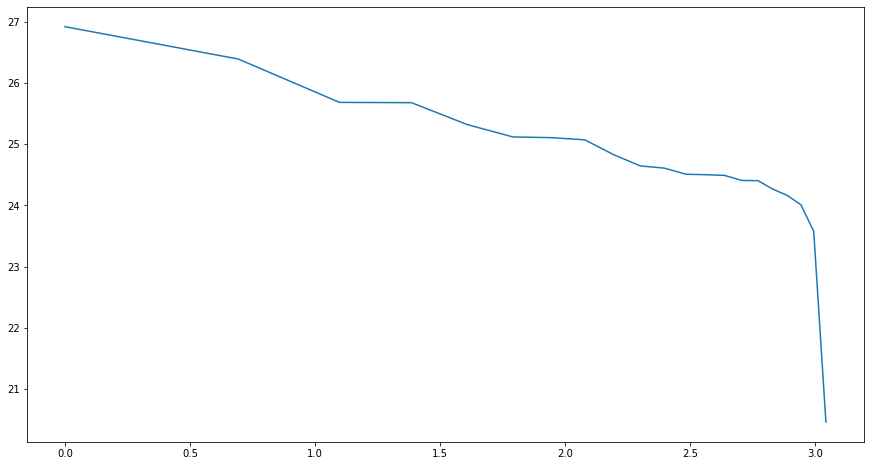

In [103]:
fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(15)

ax.plot(bb_list.Rank.iloc[:-3], bb_list['Total assets'].iloc[:-3])

In [101]:
bb_list.iloc[:-2]

,Name,Total assets,Rank
363,J.P. MORGAN SECURITIES LLC,26.919598,0.000000
590,CITIGROUP GLOBAL MARKETS INC.,26.391231,0.693147
316,"NOMURA SECURITIES INTERNATIONAL, INC.",25.682419,1.098612
56,"WELLS FARGO SECURITIES, LLC",25.677927,1.386294
420,BARCLAYS CAPITAL INC.,25.320071,1.609438
192,CREDIT SUISSE SECURITIES (USA) LLC,25.118196,1.791759
272,DEUTSCHE BANK SECURITIES INC.,25.106180,1.945910
438,HSBC SECURITIES (USA) INC.,25.071231,2.079442
616,INTERACTIVE BROKERS LLC,24.824172,2.197225
502,"CHARLES SCHWAB & CO., INC.",24.643931,2.302585


In [102]:
# duplicate rows for firms (Mirae)

In [ ]:
np.lin